In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle
import joblib
from omegaconf import OmegaConf

In [2]:
data = pd.read_csv("../data/heart.csv")
data.shape

(1000, 14)

In [3]:
data.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [4]:
y = data["target"]
X = data.drop(columns=['patientid','target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

In [5]:
len(X_train), len(X_test)

(800, 200)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train.shape

(800, 12)

In [8]:
scaler.mean_

array([4.9766250e+01, 7.6875000e-01, 1.0075000e+00, 1.5193750e+02,
       3.1404625e+02, 3.1250000e-01, 7.5000000e-01, 1.4558625e+02,
       5.0875000e-01, 2.7481250e+00, 1.5600000e+00, 1.2412500e+00])

In [9]:
X_train[:, 0].min(), X_train[:, 0].max(), X_train[:, 2].min(), X_train[:, 2].max()

(-1.6725143415733175,
 1.6987823617198097,
 -1.0532897487880573,
 2.08305689772725)

In [10]:
X_train[0]

array([ 0.40645196, -1.82327297, -1.05328975,  0.93522777,  1.53631292,
       -0.67419986,  0.32547228,  1.35413438, -1.01765584, -0.49016407,
        1.43899306,  1.79450419])

In [11]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("\n")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print(classification_report(y_test,knn_predicted))

confussion matrix
[[ 91   4]
 [  4 101]]


Accuracy of K-NeighborsClassifier: 96.0 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        95
           1       0.96      0.96      0.96       105

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



In [12]:
from sklearn.model_selection import GridSearchCV

# Define the K-Nearest Neighbors model
knn = KNeighborsClassifier()

# Define the hyperparameters grid for tuning
param_grid = {
    'n_neighbors': [5, 10, 15],             # Number of neighbors to consider
    'weights': ['uniform', 'distance'],     # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'p': [1, 2]                              # Power parameter for the Minkowski metric
}

# Perform Grid Search with 10-fold cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and best score found
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print best parameters and best score
print("Best Parameters:", best_params)
print("Best Score (accuracy):", best_score)

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Best Score (accuracy): 0.95625


In [13]:
# Train the model with best parameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

# Make predictions with the best model
best_knn_predicted = best_knn.predict(X_test)

# Evaluate the best model
best_knn_conf_matrix = confusion_matrix(y_test, best_knn_predicted)
best_knn_acc_score = accuracy_score(y_test, best_knn_predicted)

# Print confusion matrix and accuracy
print("Confusion Matrix:")
print(best_knn_conf_matrix)
print("\nAccuracy of K-Neighbors Classifier (after hyperparameter tuning):", best_knn_acc_score * 100, '\n')
print("Classification Report:")
print(classification_report(y_test, best_knn_predicted))

Confusion Matrix:
[[ 93   2]
 [  3 102]]

Accuracy of K-Neighbors Classifier (after hyperparameter tuning): 97.5 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        95
           1       0.98      0.97      0.98       105

    accuracy                           0.97       200
   macro avg       0.97      0.98      0.97       200
weighted avg       0.98      0.97      0.98       200



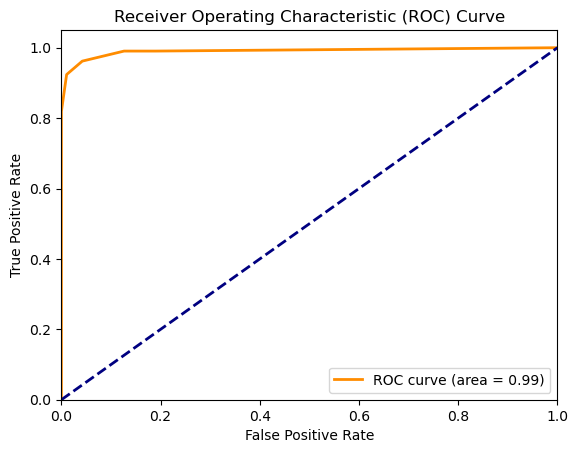

In [17]:
# Fit the classifier with training data
knn.fit(X_train, y_train)

# Compute predicted probabilities
y_pred_proba = knn.predict_proba(X_test)[:,1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
knn_predicted

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1], dtype=int64)

In [ ]:
knn_predict_proba = knn.predict_proba(X_test)
knn_predict_proba.shape

In [ ]:
knn_predict_probability = knn_predict_proba[:,1]
knn_predict_probability

In [ ]:
knn_predict_probability.shape

In [ ]:
# save the model to disk
pickle.dump(knn, open(conf["KNN_MODEL"], 'wb'))

In [ ]:
# Save the model stats
joblib.dump(knn_conf_matrix, conf["KNN_CONF_MATRIX"])

In [ ]:
# save the scaler to disk
scaler_filename = "../saved_models/knn_model_scaler"
joblib.dump(scaler, conf["KNN_SCALER"]) 

# Front End

In [16]:
conf = OmegaConf.load("../../config.yaml")

In [17]:
# Load the scaler
scaler = joblib.load(conf['KNN_SCALER'])

C:\Users\divya\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
# load the model from disk
loaded_model = pickle.load(open(conf['KNN_MODEL'], 'rb'))

C:\Users\divya\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [19]:
# Prediction - Based on FE values
features_values = np.array([53, 1, 2, 171, 0, 0, 1, 147, 0, 5.3, 3, 3]).reshape(1, -1)

In [20]:
features_values.shape

(1, 12)

In [21]:
scaled_features_values = scaler.transform(features_values)
scaled_features_values.shape

C:\Users\divya\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(1, 12)

In [15]:
fe_model_output = loaded_model.predict(scaled_features_values)
fe_model_output.shape

NameError: name 'loaded_model' is not defined

In [50]:
fe_model_output[0]

1

In [44]:
fe_model_proba_output = loaded_model.predict_proba(scaled_features_values)
fe_model_proba_output.shape

(1, 2)

In [45]:
fe_predict_probability = fe_model_proba_output[:,1]
fe_predict_probability

array([1.])

In [51]:
fe_predict_probability[0]

1.0

In [53]:
import sys

In [57]:
sys.path.append('D:\\Heart/backend/models')

In [58]:
from model_predict import ModelPrediction

In [59]:
predict_obj = ModelPrediction()

In [60]:
features = [53, 1, 2, 171, 0, 0, 1, 147, 0, 5.3, 3, 3]

In [61]:
out = predict_obj.predict_for_all_models(features)

C:\Users\divya\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\divya\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\divya\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [62]:
out

[0.999879873397533, 0.9594637441090288, 1.0]

In [7]:
import sys
print(conf['VARIABLES']['DATA_PATH'] + "\backend")

D:\Heartackend


In [5]:
sys.path

['D:\\Heart\\backend\\notebooks',
 'C:\\Users\\divya\\anaconda3\\python311.zip',
 'C:\\Users\\divya\\anaconda3\\DLLs',
 'C:\\Users\\divya\\anaconda3\\Lib',
 'C:\\Users\\divya\\anaconda3',
 '',
 'C:\\Users\\divya\\anaconda3\\Lib\\site-packages',
 'C:\\Users\\divya\\anaconda3\\Lib\\site-packages\\win32',
 'C:\\Users\\divya\\anaconda3\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\divya\\anaconda3\\Lib\\site-packages\\Pythonwin']

In [17]:
conf['VARIABLES']['DATA_PATH'] + "\\backend"

'D:\\Heart\\backend'

In [18]:
sys.path.append(conf['VARIABLES']['DATA_PATH'] + "\\backend")

In [27]:
from ..

ModuleNotFoundError: No module named 'backend'

In [28]:
sys.path

['D:\\Heart\\backend\\notebooks',
 'C:\\Users\\divya\\anaconda3\\python311.zip',
 'C:\\Users\\divya\\anaconda3\\DLLs',
 'C:\\Users\\divya\\anaconda3\\Lib',
 'C:\\Users\\divya\\anaconda3',
 '',
 'C:\\Users\\divya\\anaconda3\\Lib\\site-packages',
 'C:\\Users\\divya\\anaconda3\\Lib\\site-packages\\win32',
 'C:\\Users\\divya\\anaconda3\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\divya\\anaconda3\\Lib\\site-packages\\Pythonwin',
 'D:\\Heart\\backend']

In [24]:
import os

In [25]:
os.path.abspath("model_predict.py")

'D:\\Heart\\backend\\notebooks\\model_predict.py'

In [26]:
os.path.dirname(os.path.abspath("model_predict.py"))

'D:\\Heart\\backend\\notebooks'